In [1]:
import os
if os.getcwd().split('\\')[-1] != 'irl-chess':
    os.chdir('../')

In [2]:
import torch
import chess
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from irl_chess import load_games, get_best_move, calculate_heuristics, set_board, depth_first_search

In [3]:
path = 'data/ficsgamesdb_2021_standard_nomovetimes/ficsgamesdb_2021_standard_nomovetimes.pgn'
elo_columns = (0, 1)
length_column = 2
outcome_column = 3
moves_list, data = load_games(path)

Stored files successfully loaded


In [4]:
# Print the first 2 games and their corresponding data
for i in range(2):
    print(f"Moves {i + 1}:\n{moves_list[i]}\nWhite Elo: {data[i][elo_columns[0]]}, Black Elo: {data[i][elo_columns[1]]}, Game Length: {data[i][length_column]} moves, Outcome: {data[i][outcome_column]}\n")

Moves 1:
['Nf3', 'e6', 'e3', 'c5', 'c4', 'Nf6', 'Nd4', 'd5', 'Ne2', 'Bd6', 'cxd5', 'Nxd5', 'Nec3', 'Nxc3', 'dxc3', 'O-O', 'Bb5', 'a6', 'Bd3', 'Nc6', 'O-O', 'Ne5', 'Na3', 'Nxd3', 'Nc2', 'Nxc1', 'Rxc1', 'h6', 'e4', 'Qc7', 'Na3', 'Bxh2+', 'Kh1', 'Bf4', 'Kg1', 'Bxc1', 'Qxc1', 'Qe7', 'Rd1', 'e5', 'f3', 'Be6', 'g3', 'b5', 'f4', 'b4', 'fxe5', 'bxa3', 'bxa3', 'Bg4', 'Qb1', 'Qxe5', 'Kg2', 'Bxd1']
White Elo: 1720, Black Elo: 1525, Game Length: 54 moves, Outcome: -1

Moves 2:
['e4', 'e5', 'Nf3', 'Nc6', 'g3', 'Bc5', 'Bg2', 'd6', 'O-O', 'Bg4', 'c3', 'Nge7', 'd3', 'Qd7', 'Nbd2', 'Bh3', 'Re1', 'g5', 'Nf1', 'f6', 'Qb3', 'O-O-O', 'Be3', 'Na5', 'Qc2', 'Bxe3', 'Nxe3', 'h5', 'b4', 'Nac6', 'a4', 'a5', 'b5', 'Na7', 'c4', 'b6', 'Qc3', 'Kb7', 'Rec1', 'g4', 'Nh4', 'Bxg2', 'Kxg2', 'c5', 'bxc6+', 'Nexc6', 'Nd5', 'Qe6', 'Rab1', 'Nb4', 'Rxb4', 'axb4', 'Qxb4', 'Nc8', 'Rb1', 'Qd7', 'Nxb6', 'Qc6', 'Nd5+', 'Ka7', 'Qb8+', 'Ka6', 'Nc7+', 'Ka5', 'Qb4#']
White Elo: 1920, Black Elo: 1518, Game Length: 65 moves, Outcome: 1


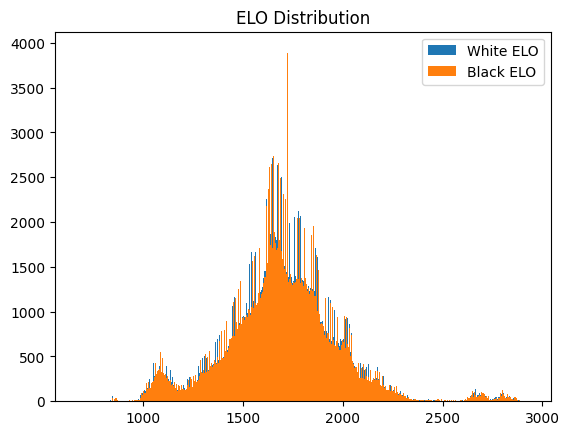

In [5]:
bins = 1000
plt.hist(data[:, elo_columns[0]], bins=bins, label='White ELO')
plt.hist(data[:, elo_columns[1]], bins=bins, label='Black ELO')
plt.title('ELO Distribution')
plt.legend()
plt.show()

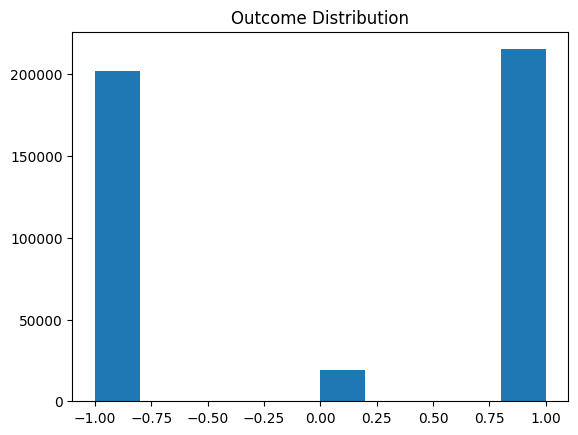

In [6]:
bins = 10
plt.hist(data[:, outcome_column], bins=bins, label='Outcome')
plt.title('Outcome Distribution')
plt.show()

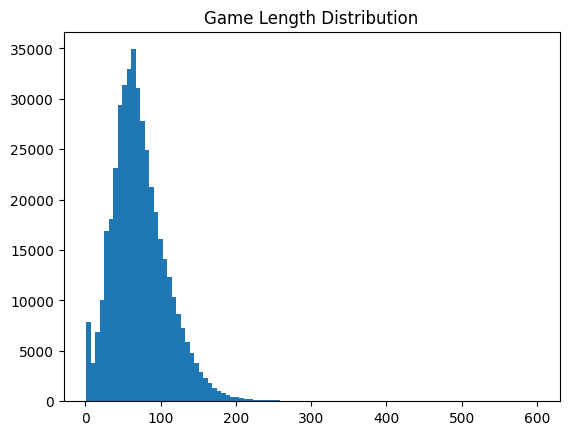

In [7]:
bins = 100
plt.hist(data[:, length_column], bins=bins, label='Game Length')
plt.title('Game Length Distribution')
plt.show()

In [8]:
# Using random weights:
print(f"The best move is: {get_best_move(chess.Board(), R=torch.rand(12), depth=3, timer=True), }")

100%|██████████| 20/20 [00:00<00:00, 97.32it/s] 

The best move is: ((Move.from_uci('g1h3'), tensor(-12.2205)),)


In [9]:
def prob_dist(R, energy, alpha, prior=lambda R: 1):
    prob = np.exp(alpha * energy) * prior(R)
    return prob

def log_prob_dist(R, energy, alpha, prior=lambda R: 1):
    log_prob = alpha * energy + np.log(prior(R))
    return log_prob

def policy_walk(R, states, moves, delta=1e-3, epochs=10, depth=3, alpha=2e-2):
    for epoch in tqdm(range(epochs)):
        add = np.random.rand(R.shape[0]).astype(R.dtype) * (delta / 2)
        R_ = R + add
        Q_moves = np.zeros(len(states))
        Q_policy = np.zeros(len(states))
        i = 0
        energy_new, energy_old = 0, 0
        for state, move in tqdm(zip(states, moves), total=len(states)):
            state.push_san(move)
            _, Q_old = get_best_move(board=state, R=R, depth=depth-1)
            _, Q_new = get_best_move(board=state, R=R_, depth=depth-1)
            state.pop()
            # _, Q_old_energy = get_best_move(board=state, R=R, depth=depth)
            
            Q_moves[i] = Q_old
            Q_policy[i] = Q_new
            
            energy_old += Q_old
            energy_new += Q_new

            i += 1

            log_prob = min(0, log_prob_dist(R_, energy_new, alpha=alpha) - log_prob_dist(R, energy_old, alpha=alpha))

            if np.sum(Q_policy < Q_moves):
                if log_prob > -1e7 and np.random.rand(1).item() < np.exp(log_prob):
                    R = R_
    return R

In [10]:
from copy import deepcopy
min_length = 10
elo_range = (1000, 1050)
boards, next_moves = [], []
for moves, data_ in tqdm(zip(moves_list, data), total=len(data)):
    if sum(elo_range[0] > data_[elo_columns[0]:elo_columns[1]+1]) + sum(data_[elo_columns[0]:elo_columns[1]+1] > elo_range[1]) or len(moves) < min_length:
        continue
    
    board = chess.Board()
    for i, move in enumerate(moves[:-1]):
        board.push_san(move)
        boards.append(deepcopy(board))
        next_moves.append(moves[i+1])

100%|██████████| 436287/436287 [00:08<00:00, 53040.57it/s]


In [11]:
theta = np.random.rand(12)
theta_star = policy_walk(theta, boards, next_moves, epochs=2, depth=3)
print(theta - theta_star)

  0%|          | 0/2 [00:23<?, ?it/s]

KeyboardInterrupt



In [ ]:
boards[11]